# Explainable recommendation
## Attentive Multitask Collaborative Filtering (AMCF) model
Plot the AMCF output preference score of the users.

In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load model
model = torch.load('AMCF_model.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

AMCF(
  (user_emb): Embedding(34550, 128)
  (item_emb): Embedding(1666, 128)
  (asp_emb): Aspect_emb()
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
    (2): Linear(in_features=25, out_features=12, bias=True)
  )
  (pdist): PairwiseDistance()
)

In [3]:
# load data
import pickle
fund = pickle.load(open('plot/fund.pkl', 'rb'))
user_dict = pickle.load(open('plot/user_dict.pkl', 'rb'))
fund_dict = pickle.load(open('plot/fund_dict.pkl', 'rb'))


In [4]:
from recommend import predict_rate
from evaluation import Evaluation

## User's overall preference

In [20]:
# get user overall preference of each aspects
users = torch.tensor(range(len(user_dict)), dtype=torch.long).to(device)
u_pred = model.predict_pref(users)
print(u_pred[0], u_pred.shape)

tensor([ 0.0452,  0.0304,  0.0270, -0.0334,  0.0797,  0.0377, -0.0156, -0.2870,
         0.3589,  0.0410,  0.0258,  0.0184], device='cuda:0',
       grad_fn=<SelectBackward0>) torch.Size([34550, 12])


## Barplot

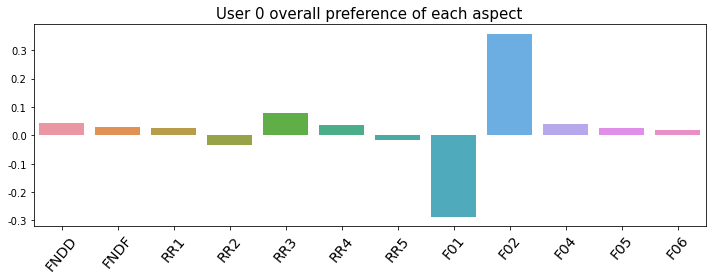

In [32]:
aspects = ['FNDD', 'FNDF', # prod_detail_type_code
            'RR1', 'RR2', 'RR3', 'RR4', 'RR5', # prod_risk_code
            'F01', 'F02', 'F04', 'F05', 'F06'] # invest_type
            
def plot_upref(uid):
    df = pd.DataFrame(u_pred[uid].cpu().detach().numpy())
    plt.figure(figsize=(10,4))
    sns.barplot(x=aspects, y=u_pred[uid].cpu().detach().numpy(), data=df)
    plt.title('User '+str(uid)+' overall preference of each aspect', fontsize=15)
    plt.xticks(rotation=50, fontsize=14)
    plt.tight_layout()
    plt.savefig('plot/overall_pref_bar.png')

plot_upref(0)

In [29]:
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

## Radar plot

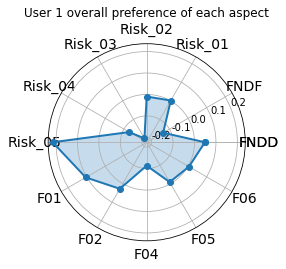

In [42]:
aspects = np.array([ 'FNDD', 'FNDF', #'國內', '境外',
       'Risk_01', 'Risk_02', 'Risk_03', 'Risk_04', 'Risk_05',
       'F01', 'F02', 'F04', 'F05', 'F06'])
    #    '股票型', '債券型', '平衡型', '貨幣型', '貨幣市場型'])

def plot_upref_radar(uid, aspects=aspects):
    stats = u_pred[uid].cpu().detach().numpy()    
    angles=np.linspace(0, 2*np.pi, len(aspects), endpoint=False)
    stats=np.concatenate((stats,[stats[0]]))
    angles=np.concatenate((angles,[angles[0]]))

    fig=plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-', linewidth=2)
    ax.fill(angles, stats, alpha=0.25)
    aspects=np.concatenate((aspects,[aspects[0]]))
    ax.set_thetagrids(angles * 180/np.pi, aspects, fontsize=14)
    ax.set_title('User '+str(uid)+' overall preference of each aspect')
    ax.grid(True)
    plt.tight_layout()
    plt.savefig('overall_pref_radar.png')

plot_upref_radar(1)

## User's specific preference
specific preference score = user's overall preference x item feature (multi-hot)  

For example, user's preference: [0.2, 0.3, 0.5], item 0's aspect: [0, 1, 1]  
-> user's specific preference on item 0: [0, 0.3, 0.5]  

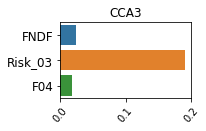

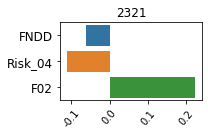

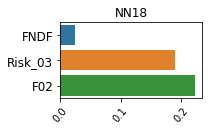

In [44]:

def plot_ui_spec_pref(uid, iid, aspects=aspects):
    fund_id = fund_dict[iid]
    # get user specific preference on item j of each aspects
    item_feature = np.array(fund[fund['fid']==iid])[0] # multi-hot value
    item_feature = list(item_feature[1:])

    spec_pref = u_pred[uid].cpu().detach().numpy()*item_feature
    asp_index = np.nonzero(spec_pref!=0)[0]
    spec_pref = (spec_pref[spec_pref!=0])

    plt.figure(figsize=(3,2))
    sns.barplot(x=spec_pref, y=aspects[asp_index], orient='h') # y=aspects
    plt.title(fund_id)
    plt.xticks(rotation=50)
    plt.yticks(fontsize=12)
    # plt.axhline(0, color='gray')
    plt.tight_layout()


plot_ui_spec_pref(58, 1175)
plot_ui_spec_pref(58, 198)
plot_ui_spec_pref(58, 1419)